In [ ]:
from common import *
from search.imports import *
from search.search import *
from search.manager import ModelManager
from features.bank import TP

In [ ]:
import globals as top_imports
top_imports.use_M = False
from given import *

In [ ]:
F, P = pd.read_pickle(big_data/'saves/train_5fixedsince+2.32.pkl')
setup_P(F=F,P=P)

In [ ]:
# cols = list(set(F1.columns)&set(F2.columns))
# F1 = F1[cols]; F2 = F2[cols];
# mate = F1,P1; dude = F2,P2;
# ##################################################################################################################
# diff = mate[0]-dude[0]
# ##################################################################################################################
# look = diff.describe().T
# ##################################################################################################################
# def iter_corr(X, Y):
#     assert (X.columns==Y.columns).all()
#     for c in X:
#         yield X[c].corr(Y[c])
# corr = pd.Series(iter_corr(mate[0],dude[0]),index=mate[0].columns,name='corr')
# look['corr'] = corr
# ###########################################
# def iter_nanmatch(X, Y):
#     assert (X.columns==Y.columns).all() and len(X)==len(Y)
#     for c in X:
#         yield 1-(X[c].isna()^Y[c].isna()).sum()/len(X[c])
# nanmatch = pd.Series(iter_nanmatch(mate[0],dude[0]),index=mate[0].columns,name='nanmatch')
# look['nanmatch'] = nanmatch
# ##################################################################################################################
# # assert nanmatch
# count = pd.concat([mate[0].count(),dude[0].count()],axis=1)
# assert (count[0]==count[1]).all()
# ###########################
# look

In [ ]:
# pd.to_pickle(look, '/big/data/debug/look.pkl')

### Features

In [ ]:
# q_ = []
# q_ += [getattr(TP,x) for x in 'ikg IKGZen IKGHomo IKGZenTenDraw IKGHomoTenDraw IKGZenVolatility IKGHomoVolatility'.split()]
# q_ += [getattr(TP,x) for x in 'Another Global IKGHomoThree IKGZenThree IKGZenThreeVP1 IKGZenThreeMoreShort'.split()]
# q_ += [getattr(TP,x) for x in 's20 s21 s22 s00 s10 s11'.split()]
# q_ += [getattr(TP,x) for x in 'IKGCover TryIt IKGCoverThreeVP1 IKGCoverThreeMoreShort'.split()]

q_ = [] # flat
q_ += [getattr(TP,x) for x in 'IKGHomo IKGHomoTenDraw'.split()]
q_ += [getattr(TP,x) for x in 'Global IKGZenThreeMoreShort'.split()]
q_ += [getattr(TP,x) for x in 's20 s21 s00 s10'.split()]
q_ += [getattr(TP,x) for x in 'TryIt'.split()]

# q_ = [] # vp10
# q_ += [getattr(TP,x) for x in 'ikg IKGZenVolatility'.split()]
# q_ += [getattr(TP,x) for x in 's20 s21 s22 s00 s10 s11'.split()]
# q_ += [getattr(TP,x) for x in 'TryIt'.split()]

### Search Params specs

In [ ]:
doWork = 'solo' # <= this is the option to change!
if doWork=='solo':
#     from search.LSP_solo import LSP
    queryFunc = 'query_solo'
elif doWork=='pair':
#     from search.LSP_pair import LSP
    queryFunc = 'query_pair'
else:
    assert False

In [ ]:
class LSP(O()):
    class Discrete(O()):
        stop = {} #{1:.45, 2:.5, 3:.55, 5:.6, 7:.65, 9:.7} #{1:.3, 3:.5, 5:.6, 7:.65}
        obo = {0: 0}
        enc = {
            'learning_rate': [.05],
            ('max_depth','num_leaves'):
                [(-1,1<<12)]
        }
        
    class OneByOne(O()):
        base = .33
        class info(O()):
            a = "main [a]rray data of 3 values, [min mid max]"
            b =  "[b]ack up value, i.e. default value if array doesn't give better results"
            cast = "function to apply to values before using to cast to the right dtype"
            lim = "maximum number of iterations of searching in this hyperparameter"
        class default(O()):
            cast = keepSigFig(2)
            lim = 0
        enc = {#TODO implement 1 sided search e.g. len(a)==2
            0: {
                'min_data_in_leaf': O(a=[1,60,375], b=120, cast=round, lim=lambda lim: lim),
                'min_sum_hessian_in_leaf': O(a=[0,50,200], b=100, lim=lambda lim: lim),
                'lambda_l1': O(a=[0,.02,.2], b=0),
                'lambda_l2': O(a=[0,.02,.2], b=0),
            }
        }

### Search Features/Samples specs

In [ ]:
from features import Features
bigF = Features(F=F, P=P)


class LSM(O()):
    model = O(
        time = 'time',
        value = 'y',
        target = 'target',
        weight = 'flat_weight',
    )
    
    metric = KaggleMetric()
    blocks = [[2009.,2009.25],[2009.5,2009.75],
              [2010.,2010.25],[2010.5,2010.75],[2011.,2011.25],[2011.5,2011.75],[2012.,2012.25],[2012.5,2012.75],
              [2013.,2013.25],[2013.5,2013.75],[2014.,2014.25],[2014.5,2014.75],[2015.,2015.25],
              #[2015.5,2015.75],[2016.,2016.25],[2016.5,2016.75],
             []]
    ndays = [P.time[P.quarter.isin(block)].nunique() for block in blocks]
    timeinfo = P[['time','quarter']].groupby('time').first().reset_index()
    
    search = LSP
    
    t_offset = 0
    num_feats = len(q_)
    num_samps = 1
    stop_samps = {2:.4, 3:.46, 4:.51, 5:.55, 6:.59, 7:.62, 8:float('inf')} #{1:.57, 2:.61, 3:.64, 4:float('inf')}
    
    early_stopping = 50
    
LSM.q_ = q_
    
    
def num_iter_map(name):
#     class Maps(O()):
#         vp10 = dict(s20=200,s21=200,s22=250,s00=1000,s10=350,s11=1000,IKGCover=600,TryIt=400,
#                     IKGCoverTenDraw=650,IKGCoverThree=650,IKGCoverThreeVP1=1500,IKGCoverThreeMoreShort=1500)
#         flat = dict(s20=100,s21=120,s22=150,s00=500,s10=150,s11=300,IKGCover=500,TryIt=550,
#                     IKGCoverTenDraw=450,IKGCoverThree=800,IKGCoverThreeVP1=800,IKGCoverThreeMoreShort=1200)
    return 1000#Maps[LSM.model.weight[:LSM.model.weight.index('_')]].get(name, 1000)
    
    
@inside(LSM)
def agg_metric(dfs, idf, index, metric):
#     return sum(dft[idf].loc[index,metric] for dft in dfs[:-1])/len(dfs[:-1]) # [:-1] because last one has no cv, is ho only
    sum1 = sum(dft[idf].loc[index, 'mean'] * n for dft,n in zip(dfs,LSM.ndays))
    sum2 = sum(dft[idf].loc[index, 'var'] * n for dft,n in zip(dfs,LSM.ndays))
    ndays = sum(LSM.ndays)
    return (sum1/ndays)/np.sqrt(sum2/ndays)

@inside(LSM)
class Step(metaclass=staticclass):
    _best = -float('inf')
    def func(results, *, t):
        t += 1
#         self = __class__
#         num_feats, num_samps, stop_samps = LSM.num_feats, LSM.num_samps, LSM.stop_samps

#         if results is not None and results['score'] > self._best:
#             self._best = results['score']

#         ts = t % num_samps
#         assert 0 not in stop_samps
#         if ts in stop_samps and stop_samps[ts] > self._best:
#             t = (t//num_samps + 1) * num_samps # go to next feature if met stop score criterion
#             ts = t % num_samps
            
#         if ts == 0: # if new feature, reset `self._best` score
#             self._best = -float('inf')
        
#         if t >= num_feats * num_samps:
#             return None
#         return t
        if t >= LSM.num_feats * LSM.num_samps:
            return None
        return t

@inside(LSM)
class Features(metaclass=staticclass):
    '''features selection groups'''
    def func(*, t):
#         t += LSM.t_offset
#         num_feats, num_samps = LSM.num_feats, LSM.num_samps
#         f, q = getattr(bigF, genFunc)(t // num_samps)
#         return O(Feats=f, Ctor=q)
        f, q = getattr(bigF, queryFunc)(LSM.q_[t])
        name = q[q.index('<')+1:q.index('>')]
        LSM.Params.data['num_iterations'] = num_iter_map(name)
        return O(Feats=f, Ctor=q)

@inside(LSM)
class Samples(metaclass=staticclass):
    '''sample learning/cv split'''
    # O(method='GroupShuffleSplit.2', kwargs=dict(n_splits=<(5)many>, test_size=.5, random_state=44), groups='quarter'),
#     def ctor2samps(ctor):
#         ho = __class__.ho
#         a, b = tuple(ctor)
#         group = bigF.Y.quarter[~ho]
#         bigF._ho = bigF.X.index[ho]
#         tr, cv = group.isin(a), group.isin(b)
#         tr, cv = [bigF.X.index[~ho][trcv] for trcv in [tr,cv]]
#         return ((tr, cv),(cv,tr))
    
#     def func(*, t):
#         ho = __class__.ho = bigF.Y.quarter>=2015.5; ho.name = None
#         t += LSM.t_offset
#         group = bigF.Y.quarter[~ho]
#         h = frozenset(group)
#         g = frozenset(random.Random(t).sample(h, len(h)//2))
#         return O(Samps=__class__.ctor2samps((g,h-g)), Ctor=(g,h-g))

    def tron2samp(cv_on):
        ho, group, time, index = __class__.ho, __class__.group, __class__.time, __class__.index
        cvind = LSM.timeinfo.index[LSM.timeinfo.quarter.isin(cv_on)]
        if len(cvind):
            tlo = LSM.timeinfo.time.loc[cvind[0]-10 if cvind[0]-10>=0 else 0]
            thi = LSM.timeinfo.time.loc[cvind[-1]+10 if cvind[-1]+10<len(LSM.timeinfo) else len(LSM.timeinfo)-1]
            tr, cv = (time<=tlo)|(time>=thi), group.isin(cv_on)
        else:
            tr, cv = ~group.isin(cv_on), ~group.isin(cv_on)
        tr, cv = [index[trcv] for trcv in [tr,cv]]
        return tr, cv

    def func(*, t):
        blocks = LSM.blocks
        ho = __class__.ho = bigF.Y.quarter>=2015.5; ho.name = None
        ok = bigF.Y.quarter.isin(set(flatten(blocks)))
        __class__.group, __class__.time, __class__.index = bigF.Y.quarter[ok], bigF.Y.time[ok], bigF.X.index[ok]
        samples = [__class__.tron2samp(block) for block in blocks]
        return O(Samps=samples, Ctor=blocks)

@inside(LSM)
class Data(metaclass=staticclass):
    '''return the X Y data tables'''
    def func(*, t):
        return bigF.X, bigF.Y
    
@inside(LSM)
class Holdout(metaclass=staticclass):
    def func(*, t):
        return [bigF.Y.quarter.isin([2015.5,2015.75]),
                bigF.Y.quarter.isin([2016.,2016.25]),
                bigF.Y.quarter.isin([2016.5,2016.75])]

@inside(LSM, name='Params')
class Params(O()):
    '''parameters constant settings'''
    data = dict(
        #num_iterations = 9999999,
        objective = 'binary',
        #early_stopping_round = 32,
        metric = 'None',
        seed = 44,
        bagging_seed = 45,
        feature_fraction_seed = 46,
    )

# LIVE TESTING WALK ONLY

In [ ]:
# @REAL
DISPLAY = True

TAG = LSM.model.weight[:LSM.model.weight.index('_')]
DIR = Path(big_data/f'love2009/{TAG}');    DIR.mkdir(exist_ok=True)

LOG_DIR = DIR/'runs';    LOG_DIR.mkdir(exist_ok=True)
LOG = logger(file=LOG_DIR/(TAG+'.log'))
SEE = LOG
import given; given.SEE = SEE

VERBOSE_EVAL = 50

In [ ]:
#from search.LSM import LSM
mm = ModelManager(DIR)
ms = ModelSearch(specs=LSM, mm=mm, tag=TAG, log=LOG.logger('>>>', display=DISPLAY), verbose_eval=VERBOSE_EVAL)
walk = ms.walk()

In [ ]:
%%time
for ii, ((fi, si), results) in enumerate(walk):
    SEE('<<<RESULTS>>>:', 'walk', ii,
        (LSM.q_[ii].lstrip()[:LSM.q_[ii].lstrip().index('>')+1] if LSM.q_[ii].lstrip()[0]=='<' else '<>'))
    for a in ['nbest', 'train', 'scores', 'score', 'holdout']:
        SEE(f'{a} = {results[a]}')

In [35]:
sharpe = lambda x: x.mean()/x.std(ddof=0)

In [36]:
qs = []
qs += 's20 s21 s22 s00 s10 s11'.split()
qs += 'IKGCover TryIt IKGCoverTenDraw IKGCoverThree IKGCoverThreeVP1 IKGCoverThreeMoreShort'.split()

In [37]:
ans = []
for name, q in zip(qs, q_):
    f, _ = getattr(bigF, queryFunc)(q)
    fi = ms.mm.F.i(Feats=f)
    pm = ms.mm.iPM(fi, 0)
    guy = pm.get('Answers', i=0)
    res = pd.concat([guy[i][0] for i in range(len(guy)-1)]+guy[-1][1:], axis=0)
    ans.append(res)

In [38]:
p = P.copy() #[P.quarter>=2010]
d = None
for name, res in zip(qs, ans):
    p['guess'] = res.guess
    p['trade'] = p.guess*p.upDown*p.absVal
    if d is None:
        d = p.groupby('time')[['trade']].sum().rename(columns={'trade':name})
    else:
        d[name] = p.groupby('time').trade.sum()

In [190]:
d[d.index>='2015-07-01'].corr()

,s20,s21,s22,s00,s10,s11,IKGCover,TryIt,IKGCoverTenDraw,IKGCoverThree,IKGCoverThreeVP1,IKGCoverThreeMoreShort
s20,1.000000,0.692006,0.875742,0.733298,0.897574,0.776941,0.737387,0.817652,0.735662,0.733535,0.729579,0.733766
s21,0.692006,1.000000,0.666268,0.739431,0.606418,0.733811,0.721834,0.597695,0.693430,0.710511,0.690098,0.711087
s22,0.875742,0.666268,1.000000,0.794343,0.882593,0.832824,0.798105,0.897839,0.783407,0.779104,0.777471,0.782869
s00,0.733298,0.739431,0.794343,1.000000,0.746203,0.934210,0.946961,0.796473,0.938566,0.936570,0.932694,0.938615
s10,0.897574,0.606418,0.882593,0.746203,1.000000,0.830780,0.815106,0.827413,0.814929,0.807558,0.807284,0.804280
s11,0.776941,0.733811,0.832824,0.934210,0.830780,1.000000,0.959173,0.781243,0.956253,0.946141,0.941559,0.943624
IKGCover,0.737387,0.721834,0.798105,0.946961,0.815106,0.959173,1.000000,0.798658,0.987185,0.988347,0.980439,0.987807
TryIt,0.817652,0.597695,0.897839,0.796473,0.827413,0.781243,0.798658,1.000000,0.791972,0.783477,0.784606,0.789224
IKGCoverTenDraw,0.735662,0.693430,0.783407,0.938566,0.814929,0.956253,0.987185,0.791972,1.000000,0.979004,0.973832,0.978744
IKGCoverThree,0.733535,0.710511,0.779104,0.936570,0.807558,0.946141,0.988347,0.783477,0.979004,1.000000,0.988029,0.997824


In [39]:
def make_values(d, lo, hi=2017):
    dt = pd.Series(d.index)
    qt = dt.dt.year+(dt.dt.quarter-1)/4
    return d[((lo<=qt)&(qt<hi)).values].values

In [51]:
qs[-1]

'IKGCoverThreeMoreShort'

In [61]:
sharpe(make_values(d, 2015.5)@np.asarray([0,1.,0,0,0,0,0,.8,0,0,0,.8]))

0.63098642192530841

In [88]:
# # DON'T DELETE IT'S WORKING CODE I DON'T WANT TO ACCIDENTALLY RUN AGAIN
# n = 1_000_000
# dd = make_values(d, 2010, 2015.5)
# cc = np.random.exponential(size=(n,dd.shape[1]))
# cc /= cc.sum(axis=1)[:,None]
# scores = [sharpe(dd@c) for c in cc]
# ibest = sorted(range(n), key=lambda i: scores[i], reverse=True)

In [183]:
list(zip(d.columns, cc[ibest[0]]))

[('s20', 0.0016357860857043429),
 ('s21', 0.36291933207142102),
 ('s22', 0.071092359736608268),
 ('s00', 0.0081941480922318611),
 ('s10', 0.045339799361505728),
 ('s11', 0.029281598344574493),
 ('IKGCover', 0.0035538438789098725),
 ('TryIt', 0.20978944617214876),
 ('IKGCoverTenDraw', 0.0047130223715880579),
 ('IKGCoverThree', 0.035747220132391684),
 ('IKGCoverThreeVP1', 0.026322606151080216),
 ('IKGCoverThreeMoreShort', 0.2014108376018357)]

0.697648204039


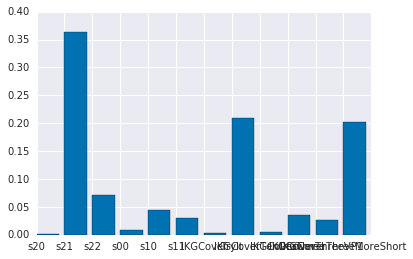

In [184]:
k = 0
print(scores[ibest[k]])
plt.bar(np.arange(d.shape[1]), tick_label=d.columns, height=cc[ibest[k]]);

In [132]:
guys = np.asarray([[scores[i], sharpe(make_values(d, 2015.5) @ cc[i])] for i in ibest[:1000:10]])

<IPython.core.display.Javascript object>


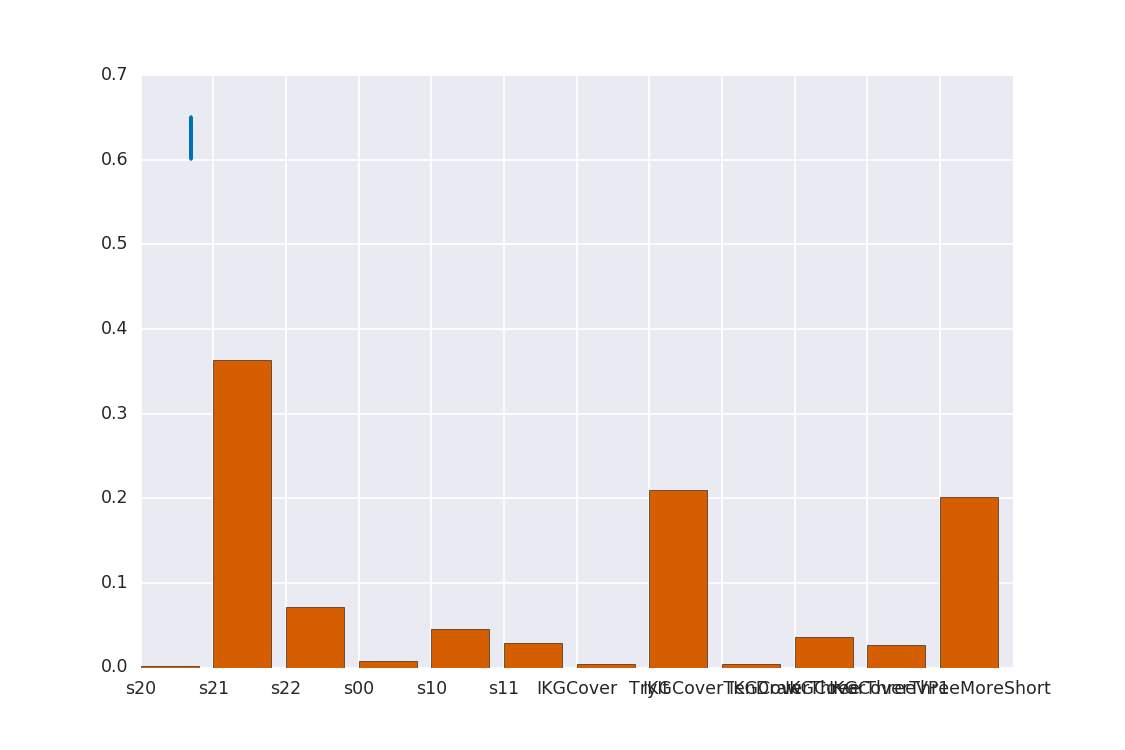

In [133]:
plt.plot(guys[:,0], guys[:,1]);

# COPY PRODUCTION

In [40]:
train_on = [2010.,2010.25,2010.5,2010.75,2011.,2011.25,2011.5,2011.75,2012.,2012.25,2012.5,
            2012.75,2013.,2013.25,2013.5,2013.75,2014.,2014.25,2014.5,2014.75,2015.,2015.25]

In [41]:
nbests = []
for name, q in zip(qs, q_):
    f, _ = getattr(bigF, queryFunc)(q)
    fi = ms.mm.F.i(Feats=f)
    pm = ms.mm.iPM(fi, 0)
    guy = pm.get('Results', i=0)
    nbests.append(guy.nbest)

In [42]:
params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0)

In [1]:
def copy_production(names, nbests, *, tag, params):
    nl = '\\n'
    for name, nbest in zip(names, nbests):
        ctor = getattr(TP, name)
        paramsUse = {'num_iterations': nbest}
        paramsUse.update(params)
        guy = f'''\
    class {name}(NamedO()):
        features = {stringify_list(bigF.query_solo(ctor)[0])}
        feats_ctor = {repr(ctor)}
        train_on = fullhouse
        weight = '{tag}_weight'
        params = {str(O(paramsUse)).replace('<>','dict').replace(' ','')}
            '''
        print(guy[:guy.rindex('\n')])

In [2]:
copy_production(qs, nbests, tag='flat', params=params, train_on=train_on)

NameError: name 'qs' is not defined

In [14]:
guy = pd.read_pickle('/big/data/nouveau/flat/models/0/0/0.Training')

In [18]:
guy[0][1]

,sharpe,mean,var
0,0.332658,0.129546,0.151653
1,0.443271,0.175665,0.157047
2,0.511819,0.217061,0.179859
3,0.554937,0.258834,0.217548
4,0.568971,0.288102,0.256397
5,0.578238,0.314607,0.296022
6,0.593902,0.352492,0.352264
7,0.602860,0.382090,0.401697
8,0.606797,0.414556,0.466746
9,0.607719,0.449362,0.546747


In [13]:
guy[0][0].dtypes

time           datetime64[ns, UTC]
assetCodeId                  int32
target                        bool
flat_weight                float64
guess                      float64
dtype: object

In [11]:
np.asarray(999909999, dtype=np.int32)

array(-884991889, dtype=int32)

In [16]:
P.dtypes

time                       datetime64[ns, UTC]
assetCode                               object
assetName                             category
universe                               float64
returnsOpenNextMktres10                float64
quarter                                float32
y                                      float64
target                                    bool
upDown                                 float32
absVal                                 float64
weight                                 float64
vp1_weight                             float64
vp5_weight                             float64
vp10_weight                            float64
always_weight                          float64
assetCodeId                            float32
flat_weight                            float64
vp20_weight                            float64
dtype: object

In [129]:
def iter_data():
    pm = ms._pm
    for pi in range(pm.nextIndex):
        print(pi)

        dfs = pm.get('Training', i=pi)
        res = pm.get('Results', i=pi)
        if res is not None:
#             res['score'] = LSM.agg_metric(dfs,1,res.nbest)
#             pm.save(Results=res, i=pi)
            yield (res.score,) + res.holdout[-1]
        else:
            yield (np.nan,)*4
dat = pd.DataFrame(iter_data(), columns=['cv','ho0','ho1','ho2'])
dat['ho'] = dat[['ho0','ho1','ho2']].mean(axis=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [130]:
dat

,cv,ho0,ho1,ho2,ho
0,0.656974,0.533162,0.738823,0.404598,0.558861
1,NaN,NaN,NaN,NaN,NaN
2,0.667761,0.514782,0.728894,0.420642,0.554773
3,0.661913,0.528658,0.734260,0.412510,0.558476
4,0.658839,0.528781,0.737129,0.399269,0.555059
5,0.663619,0.501786,0.712146,0.425697,0.546543
6,0.665765,0.520642,0.702474,0.406274,0.543130
7,0.664064,0.534007,0.731884,0.411174,0.559022
8,0.665707,0.527598,0.720939,0.421142,0.556560
9,0.658650,0.540716,0.730840,0.392689,0.554748


<IPython.core.display.Javascript object>


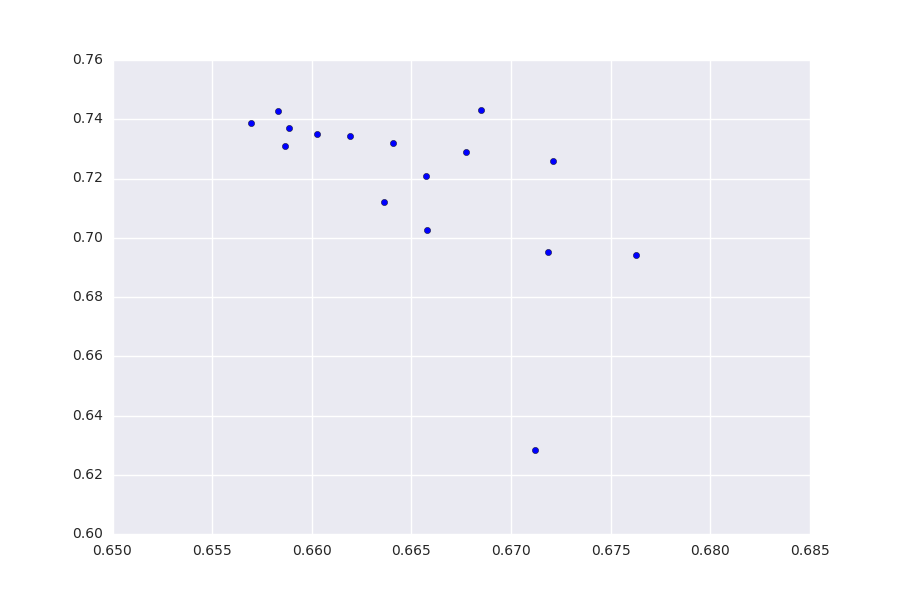

In [135]:
plt.scatter(dat.cv, dat.ho1)

# see some stuff

In [13]:
ho = LSM.Samples.ho

In [14]:
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(ms._gbm)
shap_values = explainer.shap_values(bigF.X[ho])

In [15]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], bigF.X[ho].iloc[0,:])